## Differential Expression (DE) and Differential Splicing (DS) analysis

**Inputs and Outputs**
- Inputs:
  - Harmonized and annotated short-read and long-read AnnData (raw, SCT)
- Outputs:
  - Figures
  - Tables of global and per-cluster DE and DS pvalues for all genes.

In [1]:
import os
import sys

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from time import time
import logging
import pickle
from operator import itemgetter
import json, pprint
import tables 

import scanpy as sc
import anndata

from collections import defaultdict
from itertools import groupby
from operator import itemgetter
from typing import List, Dict, Union, Any

from time import time

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

import warnings
warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'

# inputs
input_prefix = 'M132TS_immune.v4.harmonized'
output_path = 'output/t-cell-vdj-cite-seq'

# outputs
final_long_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.raw.h5ad')
final_short_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.final.raw.h5ad')
final_long_adata_sct_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.sct.h5ad')
final_short_adata_sct_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.final.sct.h5ad')

# differentially spliced
group_resolved_ds_df_csv_path = os.path.join(repo_root, output_path, f'{input_prefix}.group_resolved.ds.csv')
group_resolved_ds_de_df_csv_path = os.path.join(repo_root, output_path, f'{input_prefix}.group_resolved.ds.de.csv')
global_ds_df_csv_path = os.path.join(repo_root, output_path, f'{input_prefix}.global.ds.csv')
global_ds_de_df_csv_path = os.path.join(repo_root, output_path, f'{input_prefix}.global.ds.de.csv')

# constants
GENE_IDS_KEY = 'gencode_overlap_gene_ids'
GENE_NAMES_KEY = 'gencode_overlap_gene_names'

## Configuration

In [3]:
min_cells_per_transcript = 1
min_cells_per_gene = 50

group_cells_by_obs_key = 'mehrtash_leiden'

test_mode = True

if test_mode:
    n_mc_samples = 100
    save_results = False
    
else:
    n_mc_samples = 100_000
    save_results = True

## Preprocess

In [4]:
adata_long = sc.read(os.path.join(repo_root, final_long_adata_raw_h5_path))

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


In [5]:
adata_long

AnnData object with n_obs × n_vars = 5284 × 199246
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'mehrtash_leiden'
    var: 'transcript_ids', 'gene_ids', 'gene_names', 'transcript_names', 'de_novo_gene_ids', 'de_novo_transcript_ids', 'is_de_novo', 'is_gene_id_ambiguous', 'is_tcr_overlapping', 'gencode_overlap_gene_names', 'gencode_overlap_gene_ids', 'is_gencode_gene_overlap_ambiguous'
    uns: 'mehrtash_leiden_colors'
    obsm: 'X_pca_SCT_long', 'X_pca_SCT_short', 'X_pca_raw_short', 'X_tsne', 'X_tsne_raw_short', 'X_umap_SCT_long', 'X_umap_SCT_short'

In [6]:
total_umis = adata_long.X.sum()
log_info(f'Total UMIs: {total_umis}')

Total UMIs: 10323211.0


## Filtering

In [7]:
# remove genes that are lowly expressed
from collections import defaultdict
gene_id_to_tx_indices_map = defaultdict(list)
for i, gid in enumerate(adata_long.var[GENE_IDS_KEY].values):
    gene_id_to_tx_indices_map[gid].append(i)

included_gene_ids = []
tx_counts_i = np.asarray(adata_long.X.sum(0)).flatten()
for gid, tx_indices in gene_id_to_tx_indices_map.items():
    if np.sum(tx_counts_i[tx_indices]) >= min_cells_per_gene:
        included_gene_ids.append(gid)

adata_long = adata_long[:, adata_long.var[GENE_IDS_KEY].values.isin(included_gene_ids)]

# remove transcript that are very lowly expressed
sc.pp.filter_genes(adata_long, min_cells=min_cells_per_transcript)
tpm_threshold = 1_000_000 * min_cells_per_transcript / total_umis

log_info(f'Removing isoforms with TPM < {tpm_threshold:.2f}')

Trying to set attribute `.var` of view, copying.
Removing isoforms with TPM < 0.10


In [8]:
adata_long

AnnData object with n_obs × n_vars = 5284 × 102680
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'mehrtash_leiden'
    var: 'transcript_ids', 'gene_ids', 'gene_names', 'transcript_names', 'de_novo_gene_ids', 'de_novo_transcript_ids', 'is_de_novo', 'is_gene_id_ambiguous', 'is_tcr_overlapping', 'gencode_overlap_gene_names', 'gencode_overlap_gene_ids', 'is_gencode_gene_overlap_ambiguous', 'n_cells'
    uns: 'mehrtash_leiden_colors'
    obsm: 'X_pca_SCT_long', 'X_pca_SCT_short', 'X_pca_raw_short', 'X_tsne', 'X_tsne_raw_short', 'X_umap_SCT_long', 'X_umap_SCT_short'

## Isoform DE analysis

In [9]:
# mapping from gene id to spanning tx icatces
from collections import defaultdict
gene_id_to_tx_indices_map = defaultdict(list)
for i, gid in enumerate(adata_long.var[GENE_IDS_KEY].values):
    gene_id_to_tx_indices_map[gid].append(i)

# useful auxiliary data structures    
gene_ids = sorted(list(gene_id_to_tx_indices_map.keys()))
n_genes = len(gene_ids)
gene_id_to_gene_name_map = {
    gene_id: gene_name for gene_id, gene_name in zip(adata_long.var[GENE_IDS_KEY], adata_long.var[GENE_NAMES_KEY])}
gene_name_to_gene_id_map = {
    gene_name: gene_id for gene_id, gene_name in zip(adata_long.var[GENE_IDS_KEY], adata_long.var[GENE_NAMES_KEY])}
gene_names = list(map(gene_id_to_gene_name_map.get, gene_ids))

# mapping from gene id to spanning tx indices
group_ids = adata_long.obs[group_cells_by_obs_key].values.categories.values
group_id_to_obs_indices_map = defaultdict(list)
for group_id in group_ids:
    group_id_to_obs_indices_map[group_id] = [
        idx for idx in range(len(adata_long))
        if adata_long.obs[group_cells_by_obs_key].values[idx] == group_id]
    
# reduce tx expression by group (e.g. leiden clusters)
n_transcripts = adata_long.shape[1]
n_groups = len(group_id_to_obs_indices_map)
group_expr_gi = np.zeros((n_groups, n_transcripts), dtype=np.int)
for i_group, group_id in enumerate(group_ids):
    group_expr_gi[i_group, :] = np.asarray(adata_long.X[group_id_to_obs_indices_map[group_id], :].sum(0)).flatten()

## Global differential splicing analysis

In [10]:
from typing import Dict, Tuple, Any
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from rpy2 import rinterface as ri
from rpy2 import robjects
from rpy2.rinterface_lib.embedded import RRuntimeError

ri.initr()

def get_global_ds_pval_fisher(
        gene_id: str,
        gene_id_to_tx_indices_map: Dict[str, List[int]],
        group_expr_gi: np.ndarray,
        n_mc_samples: int = 10_000) -> Dict[str, Any]:

    tx_indices = gene_id_to_tx_indices_map[gene_id]
    n_groups = group_expr_gi.shape[0]
    x_gi = group_expr_gi[:, tx_indices]
    x_g = np.sum(x_gi, -1)
    
    if len(tx_indices) < 2:
        return {
            'pval': 1.,
            'x_g': x_g
        }
    

    def rimport(packname):
        as_environment = ri.baseenv['as.environment']
        require = ri.baseenv['require']
        require(ri.StrSexpVector([packname]),
                quiet = ri.BoolSexpVector((True, )))
        packname = ri.StrSexpVector(['package:' + str(packname)])
        pack_env = as_environment(packname)
        return pack_env
    
    rstats = rimport('stats')
    
    args = (('x', robjects.r.matrix(robjects.IntVector(x_gi.flat), nrow=n_groups, byrow=True)),
            ('simulate.p.value', True),
            ('B', n_mc_samples))
    
    try:
        out = rstats['fisher.test'].rcall(args, ri.globalenv)
        pval = float(np.array(np.array(out)[0])[0])
        
    except RRuntimeError:
        print(x_gi)
        raise RuntimeError

    return {
        'pval': pval,
        'x_g': x_g
    }

In [11]:
gene_id_to_p_values_map = dict()
gene_id_to_x_g_map = dict()

In [12]:
from typing import Tuple

remaining_gene_ids = list(set(gene_ids).difference(gene_id_to_p_values_map.keys()))
num_processes = cpu_count()

def process_gene_id(gene_id: str) -> Dict[str, Any]:

    out = get_global_ds_pval_fisher(
        gene_id=gene_id,
        gene_id_to_tx_indices_map=gene_id_to_tx_indices_map,
        group_expr_gi=group_expr_gi,
        n_mc_samples=n_mc_samples)
    
    return {
        'gene_id': gene_id,
        'pval': out['pval'],
        'x_g': out['x_g']
    }

with Pool(processes=num_processes) as pool:
    for result in tqdm(pool.imap(func=process_gene_id, iterable=remaining_gene_ids), total=len(remaining_gene_ids)):
        gene_id_to_p_values_map[result['gene_id']] = result['pval']
        gene_id_to_x_g_map[result['gene_id']] = result['x_g']

100%|██████████| 8877/8877 [00:01<00:00, 5927.85it/s]


In [13]:
# generate dataframe
group_total_counts_dict = dict()
for i_group, group_iad in enumerate(group_ids):
    group_total_counts_dict[f'expr_{i_group}'] = list(map(lambda gene_id: gene_id_to_x_g_map[gene_id][i_group], gene_ids))
group_total_counts_dict['total_expr'] = list(map(lambda gene_id: np.sum(gene_id_to_x_g_map[gene_id]), gene_ids))

ds_pval_global = list(map(gene_id_to_p_values_map.get, gene_ids))
_, ds_pval_global_adj, _, _ = multipletests(ds_pval_global, alpha=0.05, method='fdr_bh')

global_ds_df = pd.DataFrame({
    **dict(
        gene_ids=gene_ids),
    **group_total_counts_dict,
    **dict(
        ds_pval_global=ds_pval_global,
        ds_pval_global_adj=ds_pval_global_adj)},
    index=list(map(gene_id_to_gene_name_map.get, gene_ids)))

if save_results:
    global_ds_df.to_csv(global_ds_df_csv_path)

In [14]:
global_ds_df.head()

,gene_ids,expr_0,expr_1,expr_2,expr_3,expr_4,expr_5,expr_6,expr_7,total_expr,ds_pval_global,ds_pval_global_adj
DPM1,ENSG00000000419.13,12,12,25,0,29,25,101,31,235,0.009901,0.055733
C1orf112,ENSG00000000460.17,271,73,129,19,89,579,222,1258,2640,0.009901,0.055733
FUCA2,ENSG00000001036.14,12,4,29,2,30,10,39,5,131,0.693069,0.813914
NIPAL3,ENSG00000001461.17,15,3,24,2,33,18,39,35,169,0.059406,0.178399
LAS1L,ENSG00000001497.18,8,4,10,0,16,9,37,17,101,0.742574,0.853643


## Group-resolved differential splicing analysis

In [15]:
from typing import Dict, Tuple, Any
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from rpy2 import rinterface as ri
from rpy2 import robjects
from rpy2.rinterface_lib.embedded import RRuntimeError

ri.initr()

def get_group_resolved_ds_pval_fisher(
        gene_id: str,
        gene_id_to_tx_indices_map: Dict[str, List[int]],
        group_expr_gi: np.ndarray,
        n_mc_samples: int = 10_000) -> Dict[str, Any]:

    tx_indices = gene_id_to_tx_indices_map[gene_id]
    n_groups = group_expr_gi.shape[0]
    x_gi = group_expr_gi[:, tx_indices]
    x_g = np.sum(x_gi, -1)
    
    if len(tx_indices) < 2:
        return {
            'pval_g': np.ones((n_groups,)),
            'x_g': x_g
        }

    # get leave-one-out sums
    y_ggi = np.ascontiguousarray(np.repeat(x_gi[None, ...], n_groups, axis=0))
    y_ggi[np.arange(n_groups), np.arange(n_groups), :] = 0.
    y_gi = np.sum(y_ggi, axis=1)

    def rimport(packname):
        as_environment = ri.baseenv['as.environment']
        require = ri.baseenv['require']
        require(ri.StrSexpVector([packname]),
                quiet = ri.BoolSexpVector((True, )))
        packname = ri.StrSexpVector(['package:' + str(packname)])
        pack_env = as_environment(packname)
        return pack_env
    
    rstats = rimport('stats')

    pval_g = np.zeros((n_groups,))
    
    for i_group in range(n_groups):
        
        x_i = x_gi[i_group, :]
        y_i = y_gi[i_group, :]
        
        if np.sum(x_i) == 0:
            pval = 1.
        
        else:            
            contingency_table = np.hstack((x_i, y_i))
            args = (('x', robjects.r.matrix(robjects.IntVector(contingency_table.flat), nrow=2, byrow=True)),
                    ('simulate.p.value', True),
                    ('B', n_mc_samples))
            try:
                out = rstats['fisher.test'].rcall(args, ri.globalenv)
                pval = float(np.array(np.array(out)[0])[0])
            except RRuntimeError:
                print(contingency_table)
                raise RuntimeError
        
        pval_g[i_group] = pval

    return {
        'pval_g': pval_g,
        'x_g': x_g
    }

In [16]:
gene_id_to_p_values_map = dict()
gene_id_to_x_g_map = dict()

In [17]:
from typing import Tuple

remaining_gene_ids = list(set(gene_ids).difference(gene_id_to_p_values_map.keys()))
num_processes = cpu_count()

def process_gene_id(gene_id: str) -> Dict[str, Any]:

    out = get_group_resolved_ds_pval_fisher(
        gene_id=gene_id,
        gene_id_to_tx_indices_map=gene_id_to_tx_indices_map,
        group_expr_gi=group_expr_gi,
        n_mc_samples=n_mc_samples)
    
    return {
        'gene_id': gene_id,
        'pval_g': out['pval_g'],
        'x_g': out['x_g']
    }

with Pool(processes=num_processes) as pool:
    for result in tqdm(pool.imap(func=process_gene_id, iterable=remaining_gene_ids), total=len(remaining_gene_ids)):
        gene_id_to_p_values_map[result['gene_id']] = result['pval_g']
        gene_id_to_x_g_map[result['gene_id']] = result['x_g']

100%|██████████| 8877/8877 [00:05<00:00, 1746.28it/s]


In [18]:
# generate dataframe
pvalues_dict = dict()
for i_group, group_id in enumerate(group_ids):
    ds_pval_group = list(map(lambda gene_id: gene_id_to_p_values_map[gene_id][i_group], gene_ids))
    _, ds_pval_group_adj, _, _ = multipletests(ds_pval_group, alpha=0.05, method='fdr_bh')
    pvalues_dict[f'ds_pval_{i_group}'] = ds_pval_group
    pvalues_dict[f'ds_pval_adj_{i_group}'] = ds_pval_group_adj

group_total_counts_dict = dict()
for i_group, group_id in enumerate(group_ids):
    group_total_counts_dict[f'expr_{i_group}'] = list(map(lambda gene_id: gene_id_to_x_g_map[gene_id][i_group], gene_ids))
group_total_counts_dict['total_expr'] = list(map(lambda gene_id: np.sum(gene_id_to_x_g_map[gene_id]), gene_ids))

group_resolved_ds_df = pd.DataFrame({
    **dict(gene_ids=gene_ids),
    **pvalues_dict,
    **group_total_counts_dict},
    index=list(map(gene_id_to_gene_name_map.get, gene_ids)),)

if save_results:
    group_resolved_ds_df.to_csv(group_resolved_ds_df_csv_path)

In [19]:
group_resolved_ds_df.head()

,gene_ids,ds_pval_0,ds_pval_adj_0,ds_pval_1,ds_pval_adj_1,ds_pval_2,ds_pval_adj_2,ds_pval_3,ds_pval_adj_3,ds_pval_4,...,ds_pval_adj_7,expr_0,expr_1,expr_2,expr_3,expr_4,expr_5,expr_6,expr_7,total_expr
DPM1,ENSG00000000419.13,0.108911,0.526008,0.950495,1.0,0.633663,0.990671,1.000000,1.000000,0.019802,...,0.088689,12,12,25,0,29,25,101,31,235
C1orf112,ENSG00000000460.17,0.950495,1.000000,0.980198,1.0,0.009901,0.311671,0.019802,0.955338,0.009901,...,0.088689,271,73,129,19,89,579,222,1258,2640
FUCA2,ENSG00000001036.14,0.366337,0.806740,1.000000,1.0,0.831683,1.000000,0.366337,1.000000,0.405941,...,1.000000,12,4,29,2,30,10,39,5,131
NIPAL3,ENSG00000001461.17,0.019802,0.261192,0.613861,1.0,0.237624,0.793686,0.138614,1.000000,0.930693,...,0.585671,15,3,24,2,33,18,39,35,169
LAS1L,ENSG00000001497.18,0.871287,1.000000,0.613861,1.0,0.356436,0.877712,1.000000,1.000000,0.841584,...,0.831908,8,4,10,0,16,9,37,17,101


## Group-resolved differential expression analysis

In [20]:
import scipy

# get gene expression from isoform expression
row_indices = []
col_indices = []
values = []
for j, gene_id in enumerate(gene_ids):
    tx_indices = gene_id_to_tx_indices_map[gene_id]
    row_indices += tx_indices
    col_indices += [j] * len(tx_indices)
    values += [1] * len(tx_indices)
Y_ij = scipy.sparse.coo_matrix((values, (row_indices, col_indices)), shape=(n_transcripts, n_genes)).tocsr()
gex_X_nj = adata_long.X @ Y_ij

# normalize
adata_long_gex = sc.AnnData(
    X=gex_X_nj,
    obs=adata_long.obs,
    var=pd.DataFrame(index=pd.Index(list(map(gene_id_to_gene_name_map.get, gene_ids)))))

adata_long_gex.var_names_make_unique()
sc.pp.normalize_per_cell(adata_long_gex)
sc.pp.log1p(adata_long_gex)

adata_short_sct = adata_long_gex

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
group_resolved_ds_df = pd.read_csv(group_resolved_ds_df_csv_path, index_col=0)

sc.tl.rank_genes_groups(adata_short_sct, 'mehrtash_leiden', method='t-test', use_raw=False)

result = adata_short_sct.uns['rank_genes_groups']
n_groups = len(group_ids)
group_id_to_group_idx_map = {group_id: group_idx for group_idx, group_id in enumerate(group_ids)}
key_to_col_name_map = {'names': 'gene_names', 'pvals': 'de_pval', 'pvals_adj': 'de_pval_adj_scanpy'}
de_df = pd.DataFrame(
    {key_to_col_name_map[key] + '_' + str(group_id_to_group_idx_map[group_id]): result[key][group_id]
     for group_id in group_ids
     for key in ['names', 'pvals', 'pvals_adj']})

de_gene_names_list = adata_short_sct.var.index.values
de_pval_list = np.zeros((len(de_gene_names_list),))
de_gene_name_to_index_map = {gene_name: idx for idx, gene_name in enumerate(de_gene_names_list)}

In [22]:
from collections import Counter

ds_gene_names_list = group_resolved_ds_df.index.values.tolist()
mutual_gene_names_list = list(set(ds_gene_names_list).intersection(de_gene_names_list))
group_resolved_ds_df = group_resolved_ds_df.loc[mutual_gene_names_list]

gene_name_counter = Counter(group_resolved_ds_df.index.values)
bad_gene_names = set()
for gene_name, multiplicity in gene_name_counter.items():
    if multiplicity > 1:
        bad_gene_names.add(gene_name)

mutual_gene_names_list = list(set(mutual_gene_names_list).difference(bad_gene_names))
group_resolved_ds_df = group_resolved_ds_df.loc[mutual_gene_names_list]

In [23]:
group_resolved_ds_de_df = group_resolved_ds_df.copy()

for group_idx, group_id in enumerate(group_ids):
    de_group_gene_names = de_df[f'gene_names_{group_idx}'].values
    de_group_pvals = de_df[f'de_pval_{group_idx}'].values
    _, de_group_pvals_adj, _, _ = multipletests(de_group_pvals, alpha=0.05, method='fdr_bh')
    de_group_gene_name_to_index_map = {gene_name: index for index, gene_name in enumerate(de_group_gene_names)}
    group_resolved_ds_de_df[f'de_pval_{group_idx}'] = de_group_pvals[
        list(map(de_group_gene_name_to_index_map.get, mutual_gene_names_list))]
    group_resolved_ds_de_df[f'de_pval_adj_{group_idx}'] = de_group_pvals_adj[
        list(map(de_group_gene_name_to_index_map.get, mutual_gene_names_list))]

In [24]:
if save_results:
    group_resolved_ds_de_df.to_csv(group_resolved_ds_de_df_csv_path)

In [25]:
group_resolved_ds_de_df.head()

,gene_ids,ds_pval_0,ds_pval_adj_0,ds_pval_1,ds_pval_adj_1,ds_pval_2,ds_pval_adj_2,ds_pval_3,ds_pval_adj_3,ds_pval_4,...,de_pval_3,de_pval_adj_3,de_pval_4,de_pval_adj_4,de_pval_5,de_pval_adj_5,de_pval_6,de_pval_adj_6,de_pval_7,de_pval_adj_7
PGM2,ENSG00000169299.14,0.234880,0.704242,0.234880,1.00000,1.000000,1.000000,1.000000,1.0,0.197563,...,5.017890e-01,8.025912e-01,0.307476,0.457536,1.257792e-02,0.051981,0.000004,0.000017,7.010456e-04,2.033055e-03
FAM174B,ENSG00000185442.13,0.653523,0.971934,1.000000,1.00000,0.314317,0.849648,1.000000,1.0,0.549765,...,7.534824e-01,9.266448e-01,0.033228,0.083965,8.111551e-01,0.909399,0.901733,0.930452,3.832773e-02,7.370781e-02
SMPDL3A,ENSG00000172594.13,1.000000,1.000000,1.000000,1.00000,0.742183,1.000000,1.000000,1.0,0.763992,...,3.692594e-13,2.145233e-12,0.972594,0.983023,6.869153e-07,0.000010,0.000067,0.000256,1.441814e-08,7.823339e-08
PPM1N,ENSG00000213889.10,0.011860,0.194590,0.218898,1.00000,0.988850,1.000000,0.719833,1.0,0.411066,...,9.972165e-01,9.994640e-01,0.052563,0.121259,5.995305e-01,0.774903,0.152967,0.236896,7.231327e-01,7.959391e-01
RFX1,ENSG00000132005.9,0.733913,1.000000,0.172748,0.99693,0.034750,0.414734,1.000000,1.0,0.075859,...,7.236578e-01,9.188306e-01,0.062922,0.139569,2.911334e-01,0.508538,0.319734,0.426809,1.755958e-01,2.648707e-01


## Explore

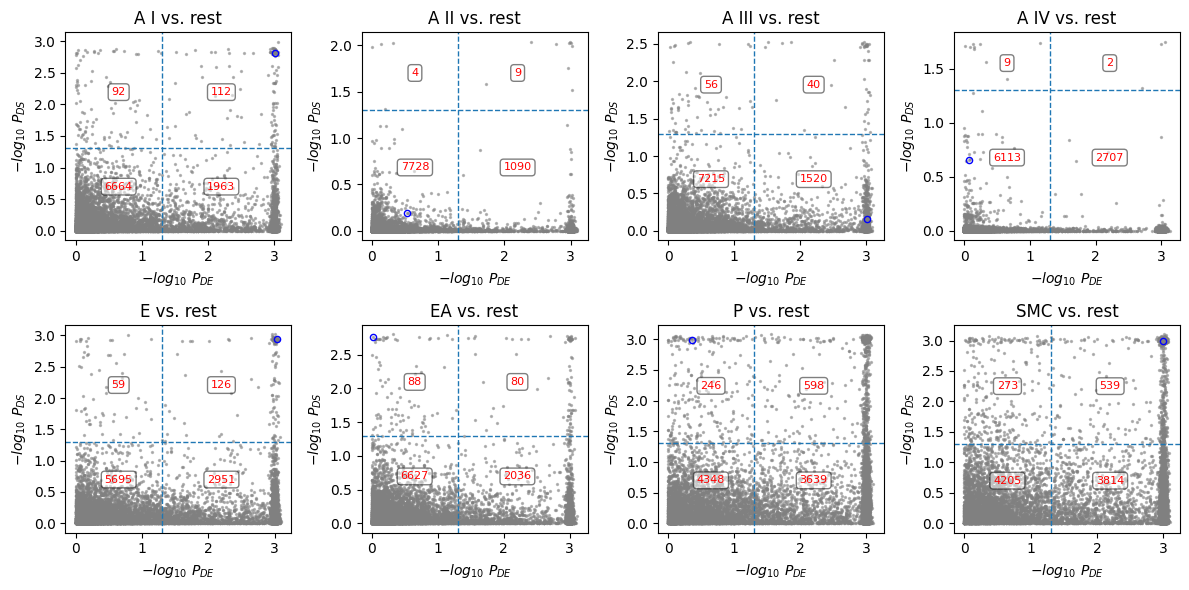

In [26]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams.update(mpl.rcParamsDefault)

ncols = 4
nrows = int(np.ceil(len(group_ids) / ncols))
scale = 3.

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(scale * ncols, scale * nrows))

highlight_map = {
    # ('RPL', 'red'): [gene_name for gene_name in gene_names if gene_name.find('RPL') == 0],
    ('PTPRC', 'blue'): ['PTPRC'],
}

x_jitter_scale = 0.01
y_jitter_scale = 0.01
max_ds_log_pval = 3.
max_de_log_pval = 3.
log10_fdr_threshold = - np.log10(0.05)
rng_seed = 0

rng = np.random.RandomState(seed=rng_seed)
gene_names_list = group_resolved_ds_de_df.index.values.tolist()
log10_tpm = np.log10(
    1_000_000 * group_resolved_ds_de_df['total_expr'].values /
    np.sum(group_resolved_ds_de_df['total_expr'].values))

for group_idx, ax in zip(range(len(group_ids)), axs.flatten()):

    X_COL_NAME = f'de_pval_adj_{group_idx}'
    Y_COL_NAME = f'ds_pval_adj_{group_idx}'

    xx = np.minimum(-np.log10(group_resolved_ds_de_df[X_COL_NAME].values), max_de_log_pval)
    yy = np.minimum(-np.log10(group_resolved_ds_de_df[Y_COL_NAME].values), max_ds_log_pval)

    n_ds = np.sum((yy > log10_fdr_threshold) & (xx <= log10_fdr_threshold))
    n_de = np.sum((xx > log10_fdr_threshold) & (yy <= log10_fdr_threshold))
    n_de_ds = np.sum((xx > log10_fdr_threshold) & (yy > log10_fdr_threshold))
    n_boring = np.sum((xx <= log10_fdr_threshold) & (yy <= log10_fdr_threshold))
    
    xx = np.maximum(0, xx + x_jitter_scale * np.max(xx) * rng.randn(len(xx)))
    yy = np.maximum(0, yy + y_jitter_scale * np.max(yy) * rng.randn(len(yy)))

    scatter = ax.scatter(
        xx,
        yy,
        color='gray',
        # c=log10_tpm,
        cmap=plt.cm.Reds,
        s=2, alpha=0.5)

    ax.axhline(log10_fdr_threshold, lw=1, linestyle='--')
    ax.axvline(log10_fdr_threshold, lw=1, linestyle='--')

    for manifest, highlighted_gene_names in highlight_map.items():
        label = manifest[0]
        color = manifest[1]
        indices = [
            gene_names_list.index(gene_name)
            for gene_name in highlighted_gene_names]
        ax.scatter(
            xx[indices],
            yy[indices],
            s=20,
            color=color,
            label=label,
            marker='o',
            facecolor=[1, 1, 1, 0],
            linewidths=1)

    ax.set_xlabel(r'$-log_{10}~P_{DE}$')
    ax.set_ylabel(r'$-log_{10}~P_{DS}$')
    
    ax.text(
        0.5 * log10_fdr_threshold, 0.5 * (np.max(yy) + log10_fdr_threshold),
        str(n_ds),
        fontsize=8,
        rotation='horizontal',
        ha='center',
        color='red',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.text(
        0.5 * log10_fdr_threshold, 0.5 * log10_fdr_threshold,
        str(n_boring),
        fontsize=8,
        rotation='horizontal',
        ha='center',
        color='red',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.text(
        0.5 * (np.max(xx) + log10_fdr_threshold), 0.5 * log10_fdr_threshold,
        str(n_de),
        fontsize=8,
        rotation='horizontal',
        ha='center',
        color='red',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.text(
        0.5 * (np.max(xx) + log10_fdr_threshold), 0.5 * (np.max(yy) + log10_fdr_threshold),
        str(n_de_ds),
        fontsize=8,
        rotation='horizontal',
        ha='center',
        color='red',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.set_title(group_ids[group_idx] + " vs. rest")


fig.tight_layout()
plt.show()

plt.savefig('./output/M132TS__DE_DS__t_test__adata_short_sct.png', dpi=100)